In [1]:
# A tutorial & demo of applying Bayes' theorem to physical model parameter extraction
# Author: Jake Coleman & Weiyao Ke

import subprocess
# git clone https://github.com/keweiyao/BayesExample
# Python3 
# python package: sklearn, numpy, matplotlib scipy, emcee (for MCMC)
# R
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy import stats
import emcee
import numpy as np


%matplotlib inline

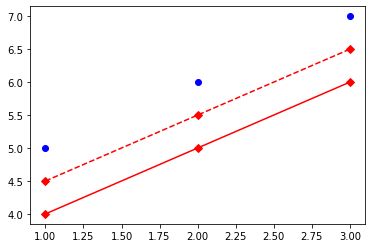

In [2]:
x = np.array([1,2,3])
y = np.array([4,5,6])
plt.plot(x,y,'rD-') #'rD-' red Dimond-shaped symbol, connected with solid lines
plt.plot(x,y+.5,'rD--')
plt.plot(x,y+1,'o', color='b')

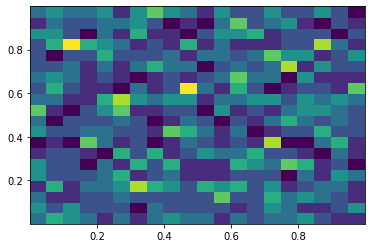

In [3]:
x = np.random.rand(1000)
y = np.random.rand(1000)
_ = plt.hist2d(x,y, bins=20)

Exercise 0 - Monte Carlo Sampling of random number according to a distribution

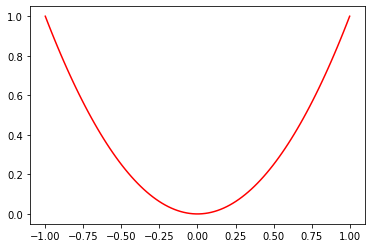

In [4]:
def TargetFun(x):
    return x**2
X = np.linspace(-1.,1.,100)
plt.plot(X, TargetFun(X), 'r-')

In [5]:
def sample_Monte_Carlo(P, N=1000, Pmax=1.0):
    counter = 0
    X = []
    while len(X)<N:
        x1 = np.random.uniform(-1,1)
        Prob = P(x1)/Pmax
        r1 = np.random.uniform(0,1)
        if r1 < Prob:
            X.append(x1)
        else:
            continue
    return np.array(X)

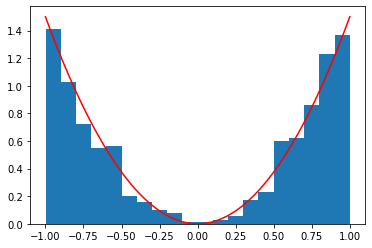

In [6]:
samples = sample_Monte_Carlo(TargetFun)
_  = plt.hist(samples, bins=20, density=True)
X = np.linspace(-1.,1.,100)
plt.plot(X, TargetFun(X)*3/2, 'r-')

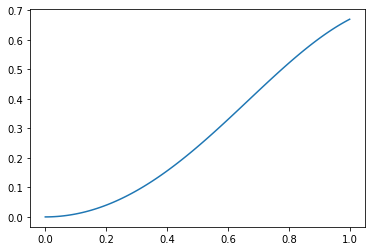

In [7]:
# Exercise 0.5 a toy Markov Chain Monte Carlo Sampler
def TargetFun2(x, a=2, b=3, c=0.4):
    if x<0:
        return 0
    if x>1:
        return 0
    else:
        return x**a*np.exp(-c*x**b)
TargetFun2 = np.vectorize(TargetFun2)
x = np.linspace(0,1,100)
Y = TargetFun2(x)
plt.plot(x, Y)

In [8]:
def ToyMCMC(P, N=1000):
    X = []
    while len(X) < N:
        walker = np.random.uniform(0,1)
        for i in range(100):
            new_x = walker + np.random.normal(0., .1)
            
            if new_x > 1:
                new_x -= 1.
            if new_x < 0:
                new_x += 1.
            # Decide whether this move is allowed
            Pold = P(walker)
            Pnew = P(new_x)
            Pupdating = np.min([Pnew/Pold, 1.0])
            r = np.random.uniform(0,1)
            if r<Pupdating:
                walker = new_x
        X.append(walker)
    return np.array(X)

In [9]:
samples = ToyMCMC(TargetFun2)

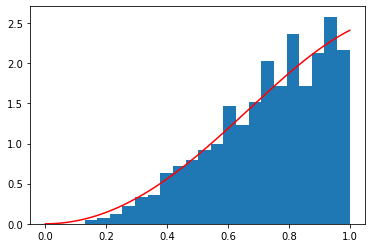

In [10]:
plt.hist(samples, bins=21, density=True)
x = np.linspace(0,1,100)
y = TargetFun2(x)
norm = y.sum()*(x[1]-x[0])
plt.plot(x, y/norm, 'r-')

### Lets try to use EMCEE package to do the same task:

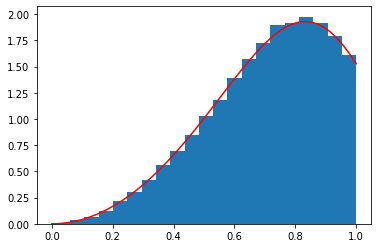

In [11]:
# Step 1, import the package (not really necessary here, as we have alraed done it when executing the first block)
import emcee

target_func_parameters = (2,5,1) # a, b, c, F(x; a, b, c) = x^a * e^{ -c*x^b }, 0<x<1
# Step 2, define the log of posterior
ranges = np.array([[0,1]])
def ln_posterior(x, a, b, c):
    if (x<ranges[:,0]).any() or (x>ranges[:,1]).any():
        return - np.inf
    else:
        return np.log( TargetFun2(x[0], a, b, c) )

# Step 3, use random walkers, usually we need > 20 independent walkers per dimension
nwalkers = 20
ndim = 1
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=target_func_parameters)
# 3.1: randomly initilize locations of walkers within (0,1)
p0 = np.random.rand(nwalkers, ndim)
# 3.2: let each walker update its location 10000 times
nsamples = 10000
out_post = sampler.run_mcmc(p0,nsamples)
# 3.3: we will only use their location after 1000 steps as random draws from the distribution
#      because each walker will take some time/steps to "thermalize" to the target function,
#      we call them burn-in steps, which are discarded from the final results
nburnin=1000
samples = sampler.chain[:, nburnin:, :].reshape((-1, ndim))

plt.hist(samples, bins=21, density=True)
x = np.linspace(0,1,100)
y = TargetFun2(x, *target_func_parameters)
norm = y.sum()*(x[1]-x[0])
plt.plot(x, y/norm, 'r-')


## Now, try to sample from a two-dimensional function

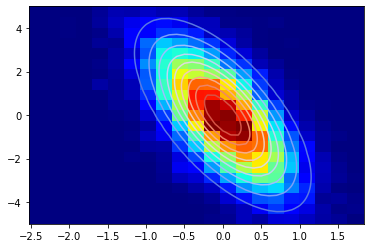

In [12]:
# Step 1, define a 2D target probability density function (in statistical science we usePDF for short, 
#     however, note that PDF means something differnet in high-energy physics & nuclear physics)
def Ftarget2D(x1, x2, a, b, c, d): # we can eitger do f(x,y) or f(xvec), where xvec is a column of two values
    return a*np.exp(- (a*x1**2 + b*x2**2 + c*x1*x2) ) # this is a 2-D Gaussian
# Step 2, define the log of posterior
ranges = np.array([[-5,5],[-5,5]])
def ln_posterior(x, a, b, c, d):
    if (x<ranges[:,0]).any() or (x>ranges[:,1]).any():
        return - np.inf
    else:
        return np.log( Ftarget2D(x[0], x[1], a, b, c, d) )

# Step 3, use random walkers, usually we need > 20 independent walkers per dimension
target_func_parameters = [3,0.2,1,2]
ndim = 2
nwalkers = 20*ndim
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=target_func_parameters)
# 3.1: randomly initilize locations of walkers within (0,1)
p0 = np.random.rand(nwalkers, ndim)
# 3.2: let each walker update its location 10000 times
nsamples = 2000
out_post = sampler.run_mcmc(p0,nsamples)
# 3.3: we will only use their location after 1000 steps as random draws from the distribution
#      because each walker will take some time/steps to "thermalize" to the target function,
#      we call them burn-in steps, which are discarded from the final results
nburnin=1000
samples = sampler.chain[:, nburnin:, :].reshape((-1, ndim))
xsamples, ysamples = samples.T

# plot the 2D histogram of the samples
_ = plt.hist2d(xsamples, ysamples, bins=21, density=True, cmap=plt.cm.jet)
# plot contours of the target function
b = np.linspace(-5,5,101)
x, y = np.meshgrid(b, b)
z = Ftarget2D(x, y, *target_func_parameters)
plt.contour(x,y,z,levels=10,cmap=plt.cm.coolwarm)


### Exercise 1 - Bayes Rule

Here, we're going to explore the mechanics of Bayesian analysis, and how prior choices can affect the posterior outcome. Let's revisit the coin example from the slides - we flipped 10 coins, and 7 came up heads. Our goal to make inference on the true probability of heads $\theta$, using Bayesian analysis. To do this, we need a likelihood and prior. 






In [13]:
coin_tosses = np.array([0,1,1,1,0,1,0,1,1,1])
num_heads = 14#sum(coin_tosses)
N = 20#len(coin_tosses)

**Likelihood**:
A common model for independent coin flips (or anything with a 0/1 outcome) is Binomial. So our likelihood is Binomial with size N = 10 and probability $\theta$:
\begin{align}
    y\sim \text{Binom}(N,\theta)
\end{align}

The mean of a Binomial random variable $Y$ with size $N$ (flips) and probability $\theta$ (probability of heads) is

\begin{align}
    \mathsf{E}(Y) = N\theta.
\end{align}

The variance of $Y$ is

\begin{align}
    \mathsf{V}(Y) = N\theta(1-\theta)
\end{align}

More information on Binomial distribution can found here: https://en.wikipedia.org/wiki/Binomial_distribution. 


**Prior**:
The most widely used prior for Binomial data and unknown probability is a Beta distribution. A Beta random variable can take value in (0,1).  

\begin{align}
    \theta\sim \text{Beta}(a, b) \equiv \theta^{a-1} (1-\theta)^{b-1} / Norm
\end{align}

The mean of a Beta random variable $\theta$ with first parameter $a$ and second paramter $b$ is

\begin{align}
    \mathsf{E}(\theta) = \frac{a}{a+b}
\end{align}

The variance of $\theta$ is

\begin{align}
    \mathsf{V}(\theta) = \frac{a + b}{(a+b)^2(a+b+1)}
\end{align}

More information on the Beta distribution can found here: https://en.wikipedia.org/wiki/Beta_distribution

Goal: Explore different priors for $\theta$ to see how the posterior of $\theta$ responds. 

#### Method 1: MCMC via python package emcee

Fill in missing pieces to calc_lnprior and calc_lnlike. These functions calculate the log of the prior and likelihood, respectively. For example, for the prior, you need to calculate the log of the pdf at theta for given parameters $a$ and $b$. Use the Wikipedia pages to find the pdfs.

Hint 1: For the Beta(a,b) prior, you will need to calculate the Beta function of parameters a and b (see the Wikipedia page). The cell below imports betln, which calculates the natural log of the Beta function.

Hint 2: For the Binomial likelihood, you'll need to calculate 
$$\left(\begin{matrix}N\\y\end{matrix}\right)$$
    
This is the number of ways to get y heads in N flips. The function nCr(N,y) in the cell below calculates this.
    

In [14]:
from scipy.special import betaln
import math

def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

print(nCr(4,2))

6


In [15]:
#Calculate the log pdf of the prior of theta
def prior_ln_pdf(theta,a,b):
    #Ensure theta is within (0,1)
    if theta <=0 or theta >=1:
        return -np.inf
    
    ##Add return ln ( theta^(a-1) * (1-theta)^{b-1} / Norm  ) 
    return (a-1)*np.log(theta) + (b-1)*np.log(1-theta)  - betaln(a,b)

#Calculate the log pdf of the likelihood of y successes (heads) in N trials (flips)
def likelihood_ln_pdf(y, theta, N):
    
    ##Add function return: ln [ (N,y) * theta^y * (1-theta)^(N-y) ]
    return np.log(nCr(N,y)) + y*np.log(theta) + (N-y)*np.log(1-theta)

# Log of the Posterior probability distribution
def posterior_ln_pdf(theta,a,b,y, N):
    ln_pr = prior_ln_pdf(theta=theta,a=a,b=b)
    
    if not np.isfinite(ln_pr):
        return -np.inf
        
    ln_like = likelihood_ln_pdf(y=y, theta=theta,  N = N)
    return ln_pr + ln_like

    Hint 3: If done correctly:

    prior_ln_pdf(theta=0.4, a = 2,b = 3) = 0.547

    likelihood_ln_pdf(theta=0.5,y=num_heads,N=10) = -2.144

In [16]:
##Check functions
#print(np.round(prior_ln_pdf(theta=0.4, a = 2,b = 3),3))
#print(np.round(likelihood_ln_pdf(theta=0.5,y=num_heads,N=10),3))

The code below sets up the sampler. $nsteps$ is the number of steps each walker will run, while $nburnin$ is the number of "burn-in" or "warmup" steps for each walker.  Our total number of samples will be $nwalkers\times (nsteps-nburnin)$ (recall we want 10,000 total samples). After running each walker for $nsteps$ and discarding the first $nburnin$, we reshape the output chain so each row is a draw from the posterior

In [17]:
def get_posterior_draws(a,b, nsamples = 100, nburnin = 50, nwalkers = 200):
    ndim = 1
    sampler = emcee.EnsembleSampler(nwalkers, 
                                    ndim, 
                                    posterior_ln_pdf, # Log of the Posterior probability distribution
                                    args=(a, b, num_heads,N))
    p0 = np.random.rand(nwalkers,ndim)
    out_post = sampler.run_mcmc(p0,nsamples)
    samples = sampler.chain[:, nburnin:, :].reshape((-1, ndim))
    
    return samples

Use the samples to find posterior means and variances

In [18]:
#Compare the prior density to the posterior samples
def plot_comparison_mcmc(prior_a, prior_b, nsamples = 100,nburnin = 50, nwalkers = 200):
    theta_grid = np.linspace(0.01,0.99,100)
    
    #Calculate the posterior density at the grid of theta values
    prior_pdf_vals = stats.beta(prior_a,prior_b).pdf(theta_grid)
    
    samples = get_posterior_draws(a = prior_a, b = prior_b,
                                  nsamples = nsamples, nburnin = nburnin, nwalkers = nwalkers)
    
    print('Prior mean is')
    print(prior_a/(prior_b+prior_b))
    print('Posterior mean is')
    print(np.round(samples.mean(),2))
    
    plt.plot(theta_grid,prior_pdf_vals,label = 'Prior Density' )
    plt.hist(samples,density = True,label = 'Posterior Samples',bins=20)
    plt.legend(loc='best', fontsize=12)
    pass

**Exercise**: In the above code, change a and b to plot a comparison of the prior density to the histogram of posterior samples for each set of priors. Also report the prior mean versus the mean of the posterior samples

1. a = 1, b = 1   Uniform Prior $$ P_0(x) = 1 $$
 
2. a = 1, b = 10  $$ P_0(x) \propto (1-x)^9 $$

3. a = 10, b = 1  $$ P_0(x) \propto x^9 $$

4. a = 30, b = 30 highly informative prior: $$ P_0(x) \propto x^{29} (1-x)^{29} $$ ($x$ is highly disfavored is $x\neq 1/2$)

Prior mean is
0.5
Posterior mean is
0.53


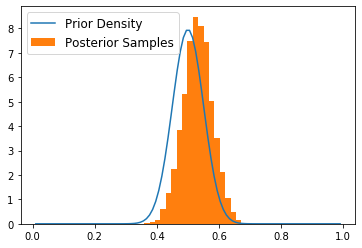

In [19]:
plot_comparison_mcmc(50,50)

#### Method 2: Direct computation of the posterior

We can find the analytics posterior in this case

First, recall the likelihood and prior

\begin{align}
	y\mid\theta&\sim \mathsf{Binom}(N,\theta)\\
	\theta&\sim \mathsf{Beta}(a,b)
\end{align}

Then, we apply Bayes Rule and do a little algebra

\begin{align}
	p(\theta\mid y)&\propto p(y\mid\theta)p(\theta)\\
	 &= \left[\begin{pmatrix}N \\ y\end{pmatrix}\theta^y(1-\theta)^{N-y}\right]\frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)}\\
	 &\propto \theta^{a+y-1}(1-\theta)^{b+N-y-1}
\end{align}
Note that when doing this algebra, we can disregard the constants $\begin{pmatrix}N \\ y\end{pmatrix}$ and $B(a,b)$ because they fall away in the proportionality.

At the end, we recognize the kernel of a $\mathsf{Beta}(a^*,b^*)$ distribution, where
\begin{align}
	a^* &= a + y\\
	b^* &= b + N - y
\end{align}
This is posterior distribution of $\theta$.

Note that this math was very simple only because of the choice of prior and likelihood; a Beta distribution is a so-called "conjugate prior" for a Binomial likelihood. For more comlicated models the posterior will not be available analytically, and we must resort to sampling methods. We only used sampling methods in this model for pedagogical purposes.

In [20]:
def plot_comparison_analytic(prior_a,prior_b, posterior_a, posterior_b,
                            nsamples = 100,nburnin = 50, nwalkers = 200):

    theta_grid = np.linspace(0.01,0.99,100)
    
    #Calculate the prior pdf at the grid of theta values
    prior_pdf_vals = stats.beta(prior_a,prior_b).pdf(theta_grid)
    plt.plot(theta_grid, prior_pdf_vals, label = 'Prior')
    plt.xlabel('Theta')
    plt.ylabel('Pdf')
    
    #Compare to MCMC-generated results
    samples = get_posterior_draws(a = prior_a, b = prior_b, 
                                 nsamples = nsamples, nburnin = nburnin, nwalkers = nwalkers)
    plt.hist(samples,density = True,label = 'Posterior Samples', bins = 20)
    
    #Calculate the posterior pdf at the grid of theta values
    posterior_pdf_vals = stats.beta(posterior_a,posterior_b).pdf(theta_grid)
    plt.plot(theta_grid,posterior_pdf_vals, label = 'Analytic Posterior')
    
    
    print('Prior mean is')
    print(prior_a/(prior_b + prior_b))
    print('Analytic posterior mean is')
    print(np.round(posterior_a/(posterior_a + posterior_b),2))
    print('Posterior mean from MCMC is')
    print(np.round(samples.mean(),2))
    
    
    plt.legend(loc='best', fontsize=12)
    pass

**Exercise**: Find the parameters for the posterior distribution of $\theta$ in our model. Compare the prior density to posterior density for the above choices of $a$ and $b$. Do the posterior densities align with the histogram of your posterior samples?

## Exercise 2 - Latin Hypercube Design

In [4]:
def generate_lhs(npoints, ndim, seed):
    """
    Generate a maximin Latin-hypercube sample (LHS) with 
    the given number of points, dimensions, and random seed.

    """

    proc = subprocess.run(
        ['R', '--slave'],
        input="""
        library('lhs')
        set.seed({})
        write.table(maximinLHS({}, {}), col.names=FALSE, row.names=FALSE)
        """.format(seed, npoints, ndim).encode(),
        stdout=subprocess.PIPE,
        check=True
    )

    lhs = np.array(
        [l.split() for l in proc.stdout.splitlines()],
        dtype=float
    )


    return lhs


def generate_random_design(npoints, ndim, seed):
    np.random.seed(seed)
    return np.random.rand(npoints, ndim)

#### Create and plot design matrix below
##### 20 points, 2 dimensions, set the seed to 80

**Exercise**: Fill in the parameters for generate_lhs(), and for plt.scatter

In [13]:
##Fill in the parameters to generate_lhs
design_LHS = generate_lhs(npoints = 50,
                      ndim = 2,
                      seed = 80)
design_random = generate_random_design(npoints = 50,ndim = 2,seed = 80)

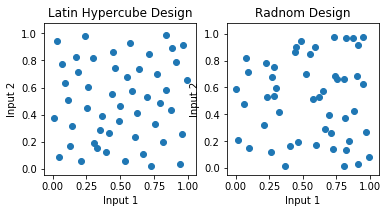

In [14]:
###Fill in parameters to plt.scatter

plt.subplot(1,2,1)
plt.scatter(x = design_LHS[:,0],
           y = design_LHS[:,1]) 
plt.title('Latin Hypercube Design')
plt.xlabel('Input 1')
plt.ylabel('Input 2')

plt.axis('square')

plt.subplot(1,2,2)
plt.scatter(x = design_random[:,0],
           y = design_random[:,1]) 
plt.title('Radnom Design')
plt.xlabel('Input 1')
plt.ylabel('Input 2')

plt.axis('square')
pass

## Exercise 3 - Gaussian Process, Toy Examples, and Usage of GP within Python-Sklearn

### 1. Single and multi-variated Gaussian distribution

A single-variable Gaussian distribution is charactered by a mean $\mu$ and a standard deviation $\sigma$

$$f(x; \mu, \sigma) = \frac{1}{(2\pi)^{1/2}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

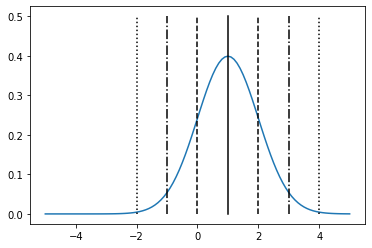

In [24]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi) * np.exp(-.5*((x-mu)/sigma)**2)
x = np.linspace(-5,5,101)
mu = 1
sigma = 1
plt.plot(x, normal(x, mu=mu, sigma=sigma))
plt.plot([mu,mu],[0,.5],'k-')
for i,line in zip([1,2,3], ['--','-.',':']):
    plt.plot([mu+i*sigma,mu+i*sigma],[0,.5],'k'+line)
    plt.plot([mu-i*sigma,mu-i*sigma],[0,.5],'k'+line)


Two-variable Gaussian distribution is charactered by the means $\mu_1, \mu_2$ of each variable and the so-called covariance matrix:

$$ \Sigma = \begin{bmatrix} s_{11} & s_{12}\\
s_{21} & s_{22}\end{bmatrix}
$$
where $s_{12}$ always equals to $s_{21}$, and $\sigma_{12}^2 <\sigma_{11} \sigma_{22}$

1. $s_{11}$: variance of varaible $x_1$, if we just focus on the value of $x_1$ without any restricts to values of $x_2$
2. $s_{22}$: variance of varaible $x_2$, if we just focus on the value of $x_2$ without any restricts to values of $x_1$
3. $s_{12}$: it tells you how would the values of $x_1$ changes (on average) when you change $x_2$. For example, if $s_{12}>0$, then when $x_2$ increases, the correspond values of $x_1$ must also increases on average. If $s_{12}<0$, then when $x_2$ increases, the correspond values of $x_1$ must decreases on average.

$$f(x_1, x_2; \mu_1, \mu_2, \Sigma_{ij}) = \frac{1}{(2\pi)^{1/2}\sqrt{|\Sigma|}} \exp\left\{-\frac{1}{2}\sum_{i,j=1}^2(x_i-\mu_i)^T \Sigma_{ij}^{-1} (x_j-\mu_j)\right\} $$

$|\Sigma|$: determination of the covariance matrix. $\Sigma^{-1}$: the inverse matrix of the covariance matrix. 

Text(0, 0.5, '$x_2$')

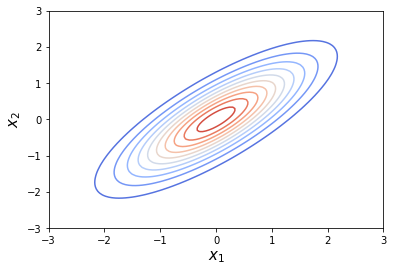

In [25]:
def f(x1,x2,mu1,mu2,SigmaInverse, DetSigma):
    X = np.array([x1-mu1,x2-mu2])
    return np.exp(-0.5*np.dot(np.dot(X,SigmaInverse),X)) / np.sqrt((2*np.pi)**2 * DetSigma)
Sigma = np.array([
[1, 0.8],
[0.8, 1]
])
SigmaInverse = np.linalg.inv(Sigma)
DetSigma = np.linalg.det(Sigma)
x = np.linspace(-3,3,101)
y = x
z = np.zeros([101,101])
for i in range(101):
    for j in range(101):
        z[i,j] = f(x[i], y[j], 0, 0, SigmaInverse, DetSigma)
plt.contour(x,y,z,levels=10,cmap=plt.cm.coolwarm)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)

Another way to represent this 2D distribution: 
 1. Pull samples x1, x2 from the 2D distribution
 2. Plot two points (1, x1) and (2, x2), like a table of tables:
 3. repead for other random samples and see what happens:
 

[Text(0, 0, 'index-1'), Text(0, 0, 'index-2')]

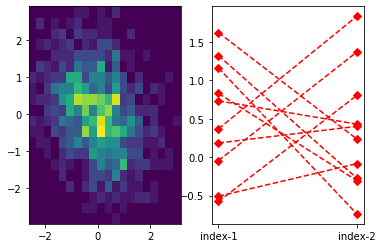

In [26]:
# we will use the built-in multi-variate normal sampler of numpy for this example
mean = [0,0]
cov = np.array([
[1, -.3],
[-0.3, 1]
])
X = np.random.multivariate_normal(mean, cov, 1000)
x1, x2 = X.T
fig, axes = plt.subplots(1,2)
_ = axes[0].hist2d(x1, x2, bins=20)

for row in X[:10]:
    ix1, ix2 = row
    axes[1].plot([1,2],[ix1,ix2],'rD--')
axes[1].set_xticks([1,2])
axes[1].set_xticklabels(["index-1", "index-2"])

[Text(0, 0, 'index-1'), Text(0, 0, 'index-2'), Text(0, 0, 'index-3')]

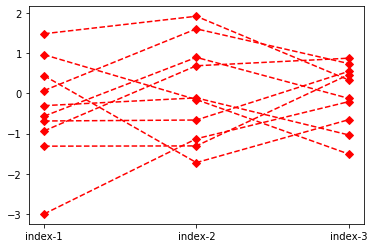

In [27]:
# How about three values?
mean = [0,0,0]
cov = np.array([
[1,  .5,  0],
[.5,  1, .5],
[0,  .5,  1]
])
X = np.random.multivariate_normal(mean, cov, 1000)
fig, ax = plt.subplots(1,1)
for row in X[:10]:
    ix1, ix2, ix3 = row
    ax.plot([1,2,3],[ix1,ix2, ix3],'rD--')
ax.set_xticks([1,2,3])
ax.set_xticklabels(["index-1", "index-2", "index-3"])

[Text(0, 0, 'index-1'),
 Text(0, 0, 'index-2'),
 Text(0, 0, 'index-3'),
 Text(0, 0, 'index-4'),
 Text(0, 0, 'index-5')]

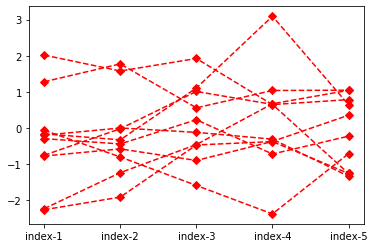

In [28]:
# How about five values?
mean = [0,0,0,0,0]
cov = np.array([
[1,  .6,  .3,   0,  0],
[.6,  1,  .6,  .3,  0],
[.3, .6,   1,  .6, .3],
[0,  .3,  .6,   1, .6],
[0,   0,  .3,  .6,  1]
])
X = np.random.multivariate_normal(mean, cov, 1000)
fig, ax = plt.subplots(1,1)
for row in X[:10]:
    ix1, ix2, ix3, ix4, ix5 = row
    ax.plot([1,2,3,4,5],[ix1,ix2,ix3,ix4,ix5],'rD--')
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(["index-1", "index-2", "index-3", "index-4", "index-5"])

Now, how about an array of many values?

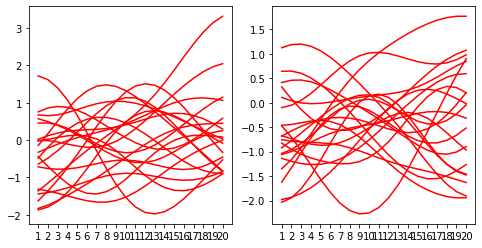

In [29]:
# How about five values?
N = 20
mean = np.zeros(N)
cov = np.zeros([N,N])
sigma0 = 1
# we will parameterize how Sigma_ij dependends on i and j

fig, (ax,ax2) = plt.subplots(1,2, figsize=(8,4))
for i in range(N):
    for j in range(N):
        abs_distance = np.abs(i-j)
        correlation_length = 7
        cov[i,j] = sigma0**2 * np.exp(-.5*(abs_distance/correlation_length)**2 )  
X = np.random.multivariate_normal(mean, cov, 100000)
for row in X[:20]:
    _ = ax.plot(np.arange(1,N+1),row,'r-')
_ = ax.set_xticks(np.arange(1,N+1))

for i in range(N):
    for j in range(N):
        abs_distance = np.abs(i-j)
        correlation_length = 7
        cov[i,j] = sigma0**2 * np.exp(-.5*(abs_distance/correlation_length)**2 ) # cov(i,j) ~ e^{ - .5 * |i-j|^2 / L^2}
        #cov[i,j] = sigma0**2 *.1/( (abs_distance/correlation_length)**2 + .1 ) # cov(i,j) ~ 1/( |i-j|^2 + 1 )
X = np.random.multivariate_normal(mean, cov, 100000)
for row in X[:20]:
    _ = ax2.plot(np.arange(1,N+1),row,'r-')
_ = ax2.set_xticks(np.arange(1,N+1))

Random draws from very-high dimensional multivariate Gaussian distribution $x_i$, with some particle type of covariance matrix $\Sigma(i,j)$, starts to look like a sample of a **random function** with $x$ as the output and the label $i$ as an input: $f: i\rightarrow x$, or $x(i)$. It is then temping to treat $i$ as a continuous varaible $x$, and call $x$ a continuous output $y$.



However, Pure random functions are not so usefull.
What if: we want all random functions to pass through some required points (impose some restrictions)
For a multi-varaite Gaussian, it is possible to require a particle $x_j$ to take a particular value and watch how the rest of $x_i, i\neq j$ behaves: conditioned multi-variate Gaussian,

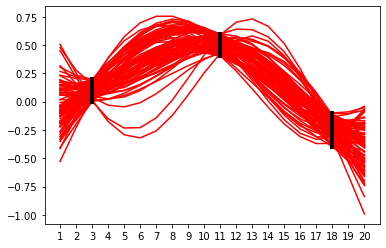

In [30]:
fig, ax = plt.subplots(1,1)
for row in X:
    if     0<row[2] and row[2]<0.2 \
       and .4<row[10] and row[10]<0.6\
       and -.4<row[17] and row[17]<-.1:
        _ = ax.plot(np.arange(1,N+1),row,'r-')
_ = ax.set_xticks(np.arange(1,N+1))
ax.plot([3,3],[0.,.2],lw=4,color='k')
ax.plot([11,11],[0.4,.6],lw=4,color='k')
ax.plot([18,18],[-0.4,-.1],lw=4,color='k')

#### Part b - example using Gaussian process emulator as provided by sklearn


Run the two cells below

In [47]:
def truth(x):
    #return(3*x+np.cos(5*x))
    return 1/x + 3*np.exp(-3*(x-2)**2) - 2 # 1/x + 3*exp(-3(x-2)^2) - 2
Ndata = 12
design = np.linspace(start=.5,stop=3,num=Ndata)
model_data = truth(design)*( 1 + np.random.normal(0,.2,Ndata) )

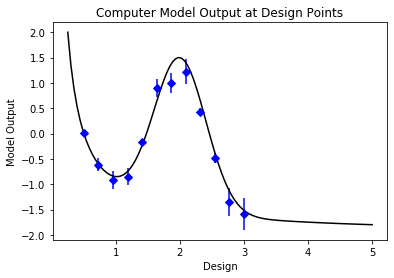

In [48]:
plt.errorbar(x=design,y=model_data, yerr=model_data*0.2,fmt='bD')
x0 = np.linspace(.25,5,100)
plt.plot(x0, truth(x0),'k-')
plt.title('Computer Model Output at Design Points')
plt.xlabel('Design')
plt.ylabel('Model Output')
pass

Run the cell below, training the GP

In [49]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

"""
Create a Gaussian process emulator, assuming a two-point function 
with correlation length L, 
C(y(x1), y(x2)) = sigma^2 * exp(-.5 * |x1-x2|^2/L^2 ) 
                # Radial basis function (RBF), squared expontial np.exp(-.5*x^2/l^2)
            + noise kernel diagnal{nl,...., nl}
Hyperparameter: L, sigma, nl
"""
ptp = .3
kernel = (
    1. * kernels.RBF(
        length_scale=ptp,
        length_scale_bounds=np.outer(ptp, (.1, 10))
    )
    + kernels.WhiteKernel(noise_level=.1**2,  noise_level_bounds=(1e-4,1e2))
)
gp = GPR(kernel=kernel, alpha=0.0, n_restarts_optimizer=1,
    copy_X_train=False, optimizer="fmin_l_bfgs_b")
gp.fit(design.reshape(-1,1), model_data)
print('RBF: ', gp.kernel_.get_params()['k1'])
print('White: ', gp.kernel_.get_params()['k2'])

RBF:  1.18**2 * RBF(length_scale=0.566)
White:  WhiteKernel(noise_level=0.0201)


**Exercise**: Create the vector of points X on which we will predict. X should be a (n x 1) numpy array (you choose n)

    Hint: We only want to predict within the bounds of our design

In [50]:
X = np.linspace(0.25,3.5,101)
X = X.reshape(-1,1)

In [51]:
#This returns the predictive mean and covariance at all the points in X
#mean is a (n,) numpy array, and cov is a (n,n) numpy array
mean, cov = gp.predict(return_cov=True, X=X)
print(mean[0], '+/-', cov[0,0]**.5)

0.45956292927804876 +/- 0.385472238026996


**Exercise**: Fill in the lines for plt.plot, top_var, and bot_var

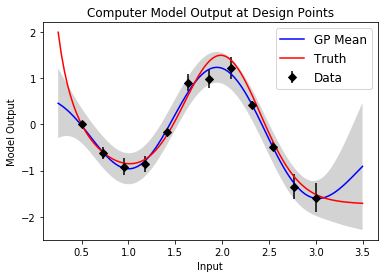

In [52]:
#Set up the figure by first plotting the output at the design points
plt.errorbar(x = design,y = model_data, yerr=model_data*.2,color = 'black',label = 'Data', fmt='D')
plt.title('Computer Model Output at Design Points')
plt.xlabel('Input')
plt.ylabel('Model Output')


#Add the mean 95% uncertainty interval of the GP predictions at all the in-between points
##Fill in parameters to plt.plot
##Find expressions for top_var and bot_var
###### Hint: For a normal distribution, how many standard deviations away from the mean is the 97.5% quantile?
###### Hint: Use the diagonal of predictive covariance matrix`
plt.plot( X, mean,color= 'blue',label = 'GP Mean')
top_var = mean + 1.96*np.sqrt(np.diag(cov))
bot_var = mean - 1.96*np.sqrt(np.diag(cov))
plt.fill_between(X[:,0], bot_var, top_var, where=top_var >= bot_var, facecolor='lightgray', interpolate=True)

plt.plot(X,truth(X),color='r',label = 'Truth')
plt.legend(loc='best', fontsize=12)

pass

#### Part c - Random Draws

The prior exercises displayed the mean and variance of our function at all the points in X. But what about actual samples of the function itself? Here we visualize what a random draw of the function would look like.

**Exercse**: Fill in the lines for top_var, bot_var, and rand_draw

    Hint: For rand_draw, examine np.random.multivariate_normal()

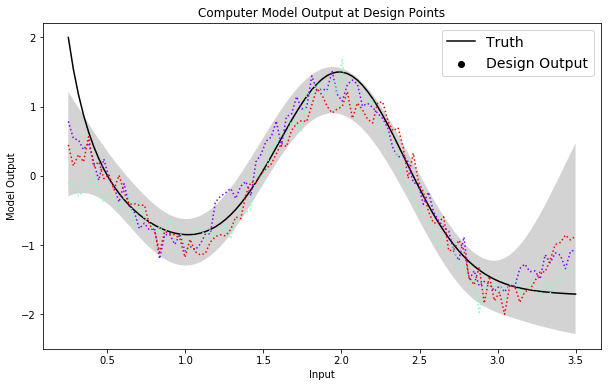

In [54]:
#Get the upper 95% quantile, and lower 95% quantile of the GP predictions at all the in-between points
##Fill in same values as previous exercise
plt.figure(figsize=(10,6))
top_var = mean + 1.96*np.sqrt(np.diag(cov))
bot_var = mean - 1.96*np.sqrt(np.diag(cov))

plt.scatter(design,model_data,color = 'black',label = 'Design Output')
plt.title('Computer Model Output at Design Points')
plt.xlabel('Input')
plt.ylabel('Model Output')
plt.fill_between(X[:,0], bot_var, top_var, where=top_var >= bot_var, facecolor='lightgray', interpolate=True)
plt.plot(X,truth(X),color='black',label = 'Truth')

ndraws = 3
colors = cm.rainbow(np.linspace(0, 1, ndraws))

#Get [ndraws] random draws from the predictive distribution of the GP at all of the in-between points 
#Use the predictive mean and covariance
rand_draw = np.random.multivariate_normal(mean,cov,ndraws)
for i in range(ndraws):
    plt.plot(X,rand_draw[i,:],color = colors[i],linestyle = ":")

plt.legend(loc='best', fontsize=14)

pass


## Exercise 4- Principal Component Analysis (PCA)

#### Ideas behind PCA:

##### Examples of dimensional redution

Consider A) the Taylor series of a a function:
$$ f(x) = a_0 + a_1 x + a_2 x^2 + \cdots
$$

and B) the Fourier series of a a function:
$$ f(x) = A_0 + A_1 \cos(x) + B_1\sin(x) + A_2 \cos(2x) + B_2\sin(2x) + \cdots\\
        = \sum_{n=0}^\infty ( A_n \cos(nx) + B_n\sin(nx))
$$
In princple, a wide class of functions can be expanded in this way. Then, instead of talking about different functions $g(x), f(x)$, we can use a series of numbers $g_n, f_n, n=0,1,\cdots$ to represents the original function. And usually one hope that with just a few terms in the expansion, the truncated series is close enough to the original function. This is what often called a "dimensional reduction": reducing an unknown function with infinitely many degrees of freedom to a small array of values ${a_n}$ to descreibe every possible case within good precision.

##### Choice of basis and efficiency of representing an unknown function 

Now consider a model $M$ that converts and input $x$ to the output $M(x)$, under the control of two parameters:
$$ M(x; a, b) = C_1(a, b) x + C_2(a,b) x^2$$
Clearly, if we happened to use Taylor series to approximate this model, we will effectively only need two values $c_1$ and $c_2$ to desribe every possible outcome of the model output $y=M(x)$ to a high precision. 

However, if one choose to use Fourier, you will need to keep many terms in the fourier expansion just to desribe a simple linear function! 

Vice versa, there are cases where the Fourier (trignometry fucntion) basis is much more efficient than the Taylor (power $x^n$) basis. So the questions is: given an ensemble of functions (or discrete data), is there an "idealized" or "customized" basis for this set of data that optimize the effiency of the expansion?


##### Principle components: an empirical set of basis customized to the data

**Exercise**: Plot the second principal component against the first

In [15]:
# Suppose we have some "Complex model" with three parameters a, b, c, d
# The model converts input x (for instance, x = pT)
# into y (e.g., cross-section) in a quite nonlinear way:
def complex_model(x, a, b, c, d, err=False):
    error = np.random.normal(0,.1,len(x))
    return (a + b*x + c*x**2 + d*x**3) *( (1 + error) if err else 1 )

However, we have no exact knowledge of the mapping. Therefore, to get an idea of what the model is doing, we sample $a,b,c,d$ randomly. And for each set (labeled by the $i^{\rm th}$ superscript) of parameters $a_i,b_i,c_i$, we can compute a set of input (x) and outputs (y). We take x to take 10 values from 0 to 1, labeld by subscript $j$. After we have finished the calculations. We will have a grid (matirix) of values that tells what the model does at each of the design point in the parmater space:
$$
(a^0, b^0, c^0): (x_0,x_j,\cdots, x_{9}) \rightarrow (y^0_0,y^0_j,\cdots, y^0_{9}) \\
(a^i, b^i, c^i): (x_0,x_j,\cdots, x_{9}) \rightarrow (y^i_0,y^i_j,\cdots, y^i_{9}) \\
(a^N, b^N, c^N): (x_0,x_j,\cdots, x_{9}) \rightarrow (y^N_0,y^N_j,\cdots, y^N_{9}) \\
$$

It looks like that you need 10 numbers (y_0, ... y_9) to describe the model output. However, we known that the model only have **3 degrees of freedom**, therefore, we should be able to tell apart the results from different parameter sets using fewer variables

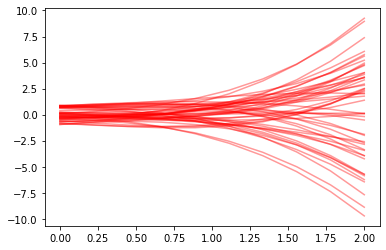

In [16]:
N = 50
a = np.random.uniform(-1,1,N)
b = np.random.uniform(-1,1,N)
c = np.random.uniform(-1,1,N)
d = np.random.uniform(-1,1,N)
x = np.linspace(0,2,10)
Y = np.array([complex_model(x,ia,ib,ic,iid) for ia, ib, ic,iid in zip(a,b,c,d)])
for y in Y:
    plt.plot(x, y, 'r', alpha=.4)

In [17]:
pca = PCA(copy=False, whiten=True, svd_solver='full')
Z = pca.fit_transform(Y)
PCs = pca.components_
Z.shape, PCs.shape

((50, 10), (10, 10))

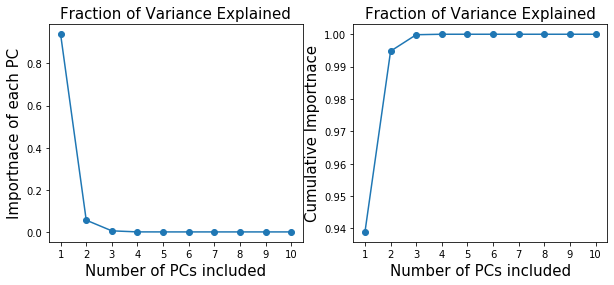

In [18]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
I = pca.explained_variance_ratio_
plt.plot(range(len(I)),I,'-o')
ticks = np.arange(0, len(I), 1)
labels = ticks + 1
plt.xticks(ticks, labels)
plt.title('Fraction of Variance Explained',fontsize=15)
plt.xlabel('Number of PCs included',fontsize=15)
plt.ylabel('Importnace of each PC',fontsize=15)

plt.subplot(1,2,2)
F_r = np.cumsum(I)
plt.plot(range(len(F_r)),F_r,'-o')
ticks = np.arange(0, len(F_r), 1)
labels = ticks + 1
plt.xticks(ticks, labels)
plt.title('Fraction of Variance Explained',fontsize=15)
plt.xlabel('Number of PCs included',fontsize=15)
plt.ylabel('Cumulative Importnace',fontsize=15)
pass

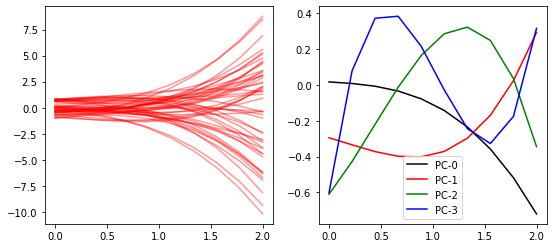

In [22]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for y in Y:
    plt.plot(x, y, 'r', alpha=.4)
plt.subplot(1,2,2)
plt.plot(x, PCs[0], 'k-', label='PC-0')
plt.plot(x, PCs[1], 'r-', label='PC-1')
plt.plot(x, PCs[2], 'g-', label='PC-2')
plt.plot(x, PCs[3], 'b-', label='PC-3')

plt.legend()

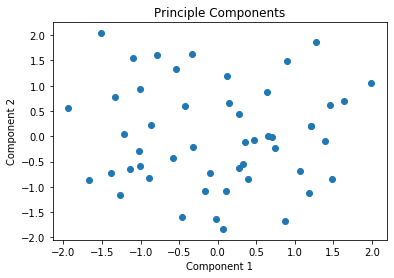

In [283]:
plt.scatter(Z[:,0],Z[:,1])
plt.title('Principle Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
pass

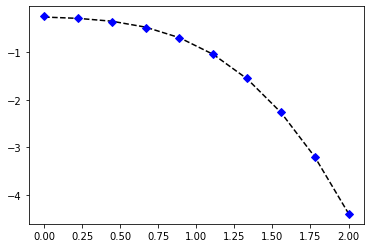

In [32]:
iverify = 0
yTrue = complex_model(x,a[iverify],b[iverify],c[iverify],d[iverify],err=False)
Npc = 3
Trans_Matrix = PCs * np.sqrt(pca.explained_variance_[:, np.newaxis])

yTruncated = np.dot(Z[iverify,:Npc], Trans_Matrix[:Npc])
#plt.plot(x, yTrue, 'k-', label='True model output')
plt.errorbar(x, Y[iverify], yerr=.0*yTrue, fmt='bD', label='output with stat error')
plt.plot(x, yTruncated, 'k--', label='Using the first three PC')

## Exercise 5 - Bayes Rule with a "Toy Jet Quenching" example

### Things to practice

In this example, we use a very simple model of jet-quenching to practice all the techniques that we have learned above. Given a measurement: yexp +/- ystat +/- ysys, and a model M : parameters --> predictions,

1) Make a parameter design on which we run the computer model

2) Use Principal Component Analysis (PCA) to do dimension reduction

3) Build Gaussian Process emulators (GP) and train on the design

4) Construct proir, likelihood and posterior function

5) Use MCMC to marginalize the posterior distribution

6) Analyse the posterior distribution of the parameters

### A toy-model for jet quenching
The energy loss $\Delta E$ of a particle with energy $E$ follows a $\Gamma$-distribution,
\begin{equation}
P(\Delta E) \propto \Delta E ^ {\left(\mu/\sigma\right)^2-1} e^{-\mu\Delta E/\sigma^2}
\end{equation}
$\mu$ and $\sigma$ are the mean and std of the energy loss distribution, parametrized as
\begin{eqnarray}
\mu &=& A \sqrt{E},\\
\sigma &=& B\mu.
\end{eqnarray}
Therefore, this model has two parameters $A, B$. We assume that

1) The model is perfect (which is often not the case).

2) The true values are $A=1$ and $B=0.5$.

### Observables and measurements

The observable is an analog of $R_{AA}$. Given a reference spectrum,

\begin{eqnarray}
\frac{dN_0}{dp_T} = \frac{p_T}{\left(3^2 + p_T^2\right)^3}
\end{eqnarray}

And the $R_{AA}$ is calcualted as the ratio between the quenched and reference spectra,

\begin{eqnarray}
R_{AA} = \frac{dN_1/dp_T}{dN_0/dp_T} =  \frac{\int d\delta p_T P(\delta p_T) \frac{dN_0}{dp_T}(p_T+\delta p_T)}{dN_0/dp_T}
\end{eqnarray}

For constructing the measurements, we consider two types of uncertainty: uncorrelated statisitcal errors and correlated systematic errors. Although the correlation among uncertainties is not one of the major topics of this example, we will see at the very end that how different treatments of the correlation affect the posterior.

In [15]:
from scipy.integrate import quad
from scipy.special import gammaln

# In this example, we use a very simple model of jet-quenching to practice all the
# all the techniques we learned above:
# Given a measurement: yexp +/- ystat +/- ysys,
#       and a model M : parameters --> predictions
# 1) Make a parameter design on which we run the computer model
# 2) Use Principal Component Analysis (PCA) to do dimension reduction
# 3) Build Gaussian Process emulators (GP) and train on the design
# 4) Construct proir, likelihood and posterior function
# 5) Use MCMC to marginalize the posterior distribution
# 6) Analyse the posterior distribution of the parameters


########### A simple model that calculates a "R_AA" ########################
# Baseline of particle production: dN0/dpT ~ pT/(3^2 + pT^2)^3
@np.vectorize
def dN0_dpT(pT):
    return pT/(3.**2 + pT**2)**3



@np.vectorize
def dN1_dpT(pT, A, B):
    # dP: The probability of a particle with pT to loose delta_pT
    # Assume: 
    #     1) delta_pT follows a Gamma Distribution
    #     2) mean-pT-loss: <delta_pT> = A*sqrt(pT)
    #     3) pT-loss-fluctuation <delta_pT^2> - <delta_pT>^2 = B*<delta_pT>
    # The two parameters A and B are to be extracted from "data"
    def dP(delta_pT, pT, A, B):
        mean = A*pT**0.5
        std = B*mean
        alpha = mean**2/std**2
        beta = mean/std**2
        x = beta*delta_pT
        return np.exp( (alpha-1.)*np.log(x) - gammaln(alpha) - x ) * beta

    # The spectrum after energy loss is a convolution of dN0/dpT and dP
    # dN1/dpT = [integral] dN0/dpT(pT+Delta_pT) * dP(Delta_pT) * d[Delta_pT]
    def f(ln_1_delta_pT, pT, A, B):
        delta_pT = np.exp(ln_1_delta_pT) - 1.
        return dN0_dpT(pT+delta_pT) * dP(delta_pT, pT+delta_pT, A, B) * (1.+delta_pT)
    result, _, = quad(f, 0.0, np.log(1+5*pT), args=(pT, A, B))
    return result

# The model without known the true value of A and B
# With what we have learned, the probablity distribution of A, B
# will be inferred from data using this model (a perfect model).
@np.vectorize
def Model(pT, A, B):
    return dN1_dpT(pT, A, B)/dN0_dpT(pT)

# Create Pseudo-data for the validation of the Bayesian workflow
# Assume the model is perfect, and the truth values of A and B are 1.0 and 0.2
### A = 1 , B = 0.2
truth = [1., 0.2]
# The Measurement measure the truth Raa, subject to limited statistics and systematic bias
# yexp = y_true + ystat + ysys
# Default: 10% relative statistical uncertainty, ystat=0
@np.vectorize
def PseudoMeasurement(StatLevel=0.05, SysLevel=0.05):
    np.random.seed(10)
    pTbin = np.array([1,2,3,4,5,6,10,15,20,30,40,60,100])
    pT = (pTbin[1:] + pTbin[:-1])/2.
    be = (pTbin[1:] - pTbin[:-1])/2.
    # truth: Raa without any uncertainty
    y_truth = Model(pT, truth[0], truth[1])
    # full results are truth +/- statistical uncertainty +/- systematic uncertainty
    stat = np.random.normal(0, StatLevel, pT.shape[0]) # on average 5% stat uncertainty, uncorrelated
    sys = np.random.normal(0, SysLevel) # on avearage, 5% sys uncertainty, fully correlated among all pT points
    results = y_truth * (1. + stat) * (1. + sys)
    return pT, be, y_truth, results, StatLevel*results, SysLevel*y_truth



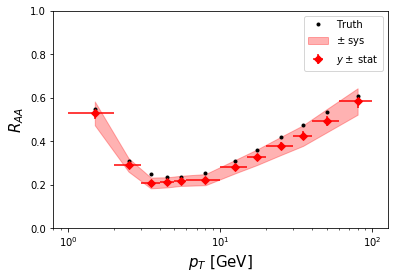

In [18]:
################Step 1: Get the Measurement########################
#  Choose the magnitudes of Stat and Sys error, (recommanded 10%)
#  1) plot the true Raa v.s. pT
#  2) plot the experimental data with stat and sys error
#
###################################################################

pT, pTbin, ytruth, yexp, ystat, ysys =\
    PseudoMeasurement(StatLevel=.05, SysLevel=.1)
    
# plot True Raa here
plt.plot(pT, ytruth, 'k.', label='Truth') 

# plot Raa measurement with stat errorbars
plt.errorbar(x=pT, xerr=pTbin, y=yexp, yerr=ystat, 
            fmt='rD', label=r"$y \pm$ stat") 

# plot sys errorband, y1:lowerbounds, y2: higherbounds
plt.fill_between(x=pT, y1=yexp-ysys, y2=yexp+ysys, 
                 color='r', alpha=.3, label=r"$\pm$ sys")

plt.ylim(0,1)
plt.semilogx()
plt.xlabel(r'$p_T$ [GeV]', fontsize=15)
plt.ylabel(r'$R_{AA}$', fontsize=15)
plt.legend()
pass


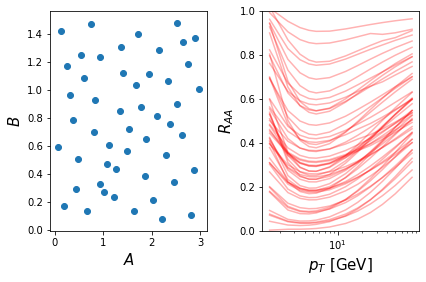

In [20]:
################Step 2: ###################################
# Make a design over the parameter space (A, B)
# 1) What is a reasonable range of the prior?
# 2) Generate the design and rescale it to the desired range
#    Hint: linear rescale x from (0,1) to y from (a,b):
#           y = (1-x)*a + x*b
# 3) Run model() on each design points
#    The design matrix model_data should have a shape: 
#           N_design x N_pT
#[amin, amax]
rangeA = [0.05, 3.0]  # Range of Prior for param A
rangeB = [0.05, 1.5]  # Range of Prior for param B
ranges = np.array([rangeA, rangeB])
hypercube = generate_lhs(npoints=50, ndim=2, seed=80) # [0,1]
#hypercube = generate_random_design(npoints=50, ndim=2, seed=80)
design = (1.-hypercube)*ranges[:, 0] + hypercube*ranges[:, 1] # rescale the hypercube to desired range
# Run model on design points
model_data = np.array([Model(pT, a, b) for (a, b) in design]) # 50 sets of Raa computed at different 
                                                              # design point in the parameter space

# plot design points
plt.subplot(1,2,1)
plt.scatter(design.T[0], design.T[1])
plt.xlabel("$A$", fontsize=15)
plt.ylabel("$B$", fontsize=15)
# plot all calulations
plt.subplot(1,2,2)
for y in model_data:
    plt.plot(pT, y, 'r-', alpha=0.3)
    plt.ylim(0,1)
plt.semilogx()
plt.xlabel(r'$p_T$ [GeV]', fontsize=15)
plt.ylabel(r'$R_{AA}$', fontsize=15)
plt.tight_layout(True)

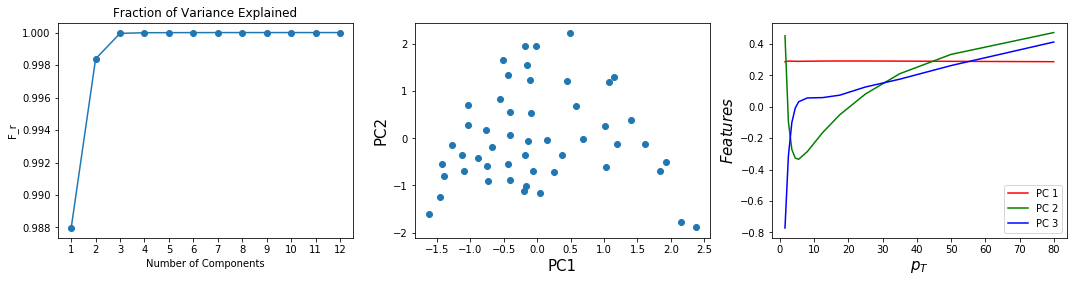

In [22]:
###### Step 3: apply PCA ######################################
# We don't need a separate GP for each pT point
# 1) Try keeping different number of principal components (npc).
#    How many pc(s) do you think is enought for this exercises?
# 2) Take a look at the feature of each pc (figure 3).
#    What each pc does in terms of decomposing the data?
# 3) Look at the coorelation between PC1 and PC2 (figure 2),
#    are they completely uncorrelated? Combine with your
#    observations from (figure 3), can you explain what
#    causes the correlation?
################################################################
npc = 3 # choose how much PCs to construct the calculation
scaler = StandardScaler(copy=True)
pca = PCA(copy=True, whiten=True, svd_solver='full')

# Keep only the first `npc` principal components
Z = pca.fit_transform(scaler.fit_transform(model_data))[:,:npc]

# The transformation matrix from PC to Physical space
Trans_Matrix = (  pca.components_
                * np.sqrt(pca.explained_variance_[:, np.newaxis])
                * scaler.scale_)
# Estimate the covariance of the negelected PCs
Residual_Cov = np.dot(Trans_Matrix[npc:].T, Trans_Matrix[npc:])

# ...
plt.figure(figsize=(15,4))
F_r = np.cumsum(pca.explained_variance_ratio_)
plt.subplot(1,3,1)
plt.plot(range(len(F_r)),F_r,'-o')
ticks = np.arange(0, len(F_r), 1)
labels = ticks + 1
plt.xticks(ticks, labels)
plt.title('Fraction of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('F_r')

plt.subplot(1,3,2)
plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)

plt.subplot(1,3,3)
for i, (comp, color) in \
        enumerate(zip(pca.components_, 'rgb')):
    plt.plot(pT, comp, color=color, label='PC {}'.format(i+1))
plt.xlabel('$p_T$', fontsize=15)
plt.ylabel('$Features$', fontsize=15)
plt.legend()
plt.tight_layout(True)

In [24]:
######## Step 4-1: Building Emulators #############################
# Using an Exp-Squared kernel + a white kernel (accounting 
# for numerical error of model calculations)
# 1) Put in initial length scales for param A and B
# 2) Put in reasonable lenght scales bounds for optimization
# 3) Fit separate emulatior to each principal component.
#    Take a look at the optimized hyper-parameters.
#    What do they mean?
kernel = (
    1. * kernels.RBF(
        length_scale=[1, 1],
        length_scale_bounds=[(.1,10), (.1, 10)]
    )  
    + kernels.WhiteKernel(.1)
)

# Build and train each GP
gps = [ GPR(kernel=kernel, n_restarts_optimizer=10) 
        for i in range(npc) ] # only build GP emulators for the first Npc principle components
# Print the optimized GP hyperparameters (variacne, correlation length, and white noise level) for sanity check
for i, gp in enumerate(gps):
    gp.fit(design, Z[:,i])
    print('RBF: ', gp.kernel_.get_params()['k1'])
    print('White: ', gp.kernel_.get_params()['k2'])

RBF:  3.16**2 * RBF(length_scale=[1.45, 1.64])
White:  WhiteKernel(noise_level=1e-05)
RBF:  7.55**2 * RBF(length_scale=[1, 0.988])
White:  WhiteKernel(noise_level=1.82e-05)
RBF:  2.57**2 * RBF(length_scale=[0.51, 0.671])
White:  WhiteKernel(noise_level=3.73e-05)


/home/weiyao/miniconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.56163621e-05, -1.70529984e-04, -7.42459051e-05,  4.80120592e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 33, 'warnflag': 2}
  ConvergenceWarning)


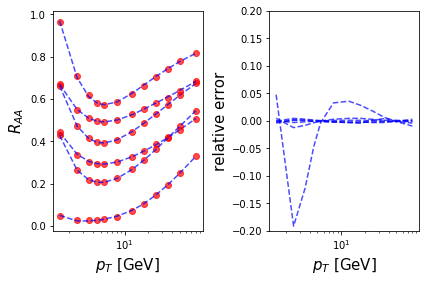

In [25]:
### Step 4-2: Validating the emulators #######################
# It is important to validate the performance of emulators to
# make sure they behave as expected.
# 1) Pick 6 random combinations of A and B. Compare the
#    emulators prediction and the model calculations.
#    Do they agree? 
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
for (a, b) in [(.4,.22), (2.3,1.2), (2.2,.11), 
               (1.32,.53), (.9,.83), (1.1,1.43)]:
    # GP prediction
    z = np.array([gp.predict([(a, b)])[0] for gp in gps])
    pred = np.dot(z, Trans_Matrix[:z.shape[-1]])
    pred += scaler.mean_
    # model calcuatlion
    calc = Model(pT, a, b)
    
    ax1.plot(pT, calc, 'ro', alpha=0.7)
    ax1.plot(pT, pred, 'b--', alpha=0.7)
    ax2.plot(pT, (pred-calc)/calc, 'b--', alpha=0.7)

ax1.semilogx()
ax1.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax1.set_ylabel(r'$R_{AA}$', fontsize=15)
ax2.set_ylim(-.2, .2)
ax2.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax2.set_ylabel('relative error', fontsize=15)

plt.tight_layout(True)

In [27]:
##### Helper functions for this block ###################
from scipy.linalg import lapack
# calculate the log of Gaussian density with 
# residual dy = y-mu and covariance matrix cov.
# - 1/2 * dy^T * cov^[-1] * dy - 1/2*ln(|cov|)
def lnLL(dy, cov):
    L, info = lapack.dpotrf(cov, clean=False)
    alpha, info = lapack.dpotrs(L, dy)
    return -.5*np.dot(dy, alpha)-np.log(L.diagonal()).sum()

# Transform a covariance matrix from the PC space 
# back to the physical space
def transform_cov(std):
    cov = np.matmul(Trans_Matrix[:npc].T*std**2, 
                    Trans_Matrix[:npc])\
        + Residual_Cov 
    return cov

####### Step 5: Construct the posterior #################
# Remember that from Bayes' Theorem:
#      Posterior  = prior * likelihood
# and:
#      ln(Posterior) = ln(prior) + ln(likelihood)
# and:
#      theta = [A, B]
# 1) Complete the returns of the prior "prior_ln_pdf(theta)"
# 2) The sys-error is correlated, while the stat one is not
#    We provide two types of covariance matrixx
#        2.1) cov_exp1 treats sys-error as uncorrelated
#        2.2) cov_exp2 treats sys-error as correlated
#    Start with 2.1) and later try 2.2) to see the effects
#    on the posterior distribution of A and B.
# 3) Complete the likelihood_ln_pdf(theta) function
def prior_ln_pdf(theta):
    if (theta<ranges[:,0]).any() or (theta>ranges[:,1]).any():
        return -np.inf
    else:
        return 0.

# Pick your experimental covariance matrix
Assume_SysError_Corr = True
""" if this is true, then UNcertainty Matrix = 
[stat1^2 0       0
 0       stat2^2 0
 0       0       stat3^2]
+
[sys1*sys1  sys1*sys2   sys1*sys3
 sys2*sys1  sys2*sys2   sys2*sys3
 sys3*sys1  sys3*sys2   sys3*sys3]
"""

""" if this is False, then UNcertainty Matrix = 
[stat1^2 0       0
 0       stat2^2 0
 0       0       stat3^2]
+
[sys^2 0       0
 0       sys2^2 0
 0       0       sys3^2]
"""
cov_exp = np.diag(ystat**2) + np.outer(ysys, ysys) \
          if Assume_SysError_Corr else \
          np.diag(ystat**2) + np.diag(ysys**2)

def likelihood_ln_pdf(theta):
    z, stdz = np.array([gp.predict([theta], return_std=True) for gp in gps]).T[0]
    pred = np.dot(z, Trans_Matrix[:z.shape[-1]])
    pred += scaler.mean_
    cov_emulator = transform_cov(std=stdz)
    dy = pred-yexp
    cov = cov_exp + cov_emulator
    return lnLL(dy, cov)

# Finally ln(Posterior) = ln(prior) + ln(likelihood)
def posterior_ln_pdf(theta):
    ln_pr = prior_ln_pdf(theta)
    ln_like = likelihood_ln_pdf(theta) 
    return ln_pr + ln_like


In [29]:
######### Step 6: Run MCMC ###########################
# Fill 1) the number of samples 2) burnin steps
# 3) dimsional of the problem 4) number of mcmc walkers
# Hint: this may take a while, so start with smaller numbers
nsteps = 2000
nburnin = 400
ndim = 2
nwalkers = 20 * ndim
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior_ln_pdf)
p0 = np.random.rand(nwalkers, ndim)
p0 = (1.-p0)*ranges[:, 0] +  p0*ranges[:, 1]
out_post = sampler.run_mcmc(p0, nsteps)
samples = sampler.chain[:, nburnin:, :].reshape((-1, ndim))

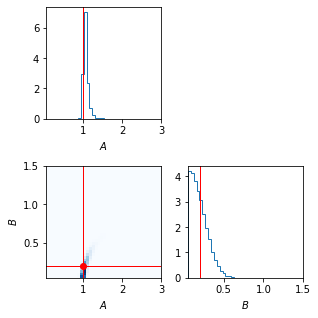

In [32]:
##### Step 7: Analyze the posterior distribution ########
# 1) Run this block and plot the posterior distribution
# 2) Does the posterior fairly estimates the true values (red)?
# 3) How does the posterior change it we take into account the
#    correlation among the sys-error?
figure, axes = plt.subplots(figsize=(4.5,4.5), ncols=ndim, nrows=ndim)
names = [r"$A$", r"$B$"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(samples[:,i], bins=40,
                    range=ranges[i], histtype='step', 
                    density=True)
            ax.set_xlabel(names[i])
            ax.axvline(x=truth[i], color='r', linewidth=1)
            ax.set_xlim(*ranges[j])
        if i>j:
            ax.hist2d(samples[:, j], samples[:, i], 
                      bins=40, range=[ranges[j], ranges[i]], 
                      cmap='Blues')
            ax.set_xlabel(names[j])
            ax.set_ylabel(names[i])
            ax.axvline(x=truth[j], color='r', linewidth=1)
            ax.axhline(y=truth[i], color='r', linewidth=1)
            ax.plot(truth[j], truth[i], 'ro')
            ax.set_xlim(*ranges[j])
            ax.set_ylim(*ranges[i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig("corr-results.pdf")

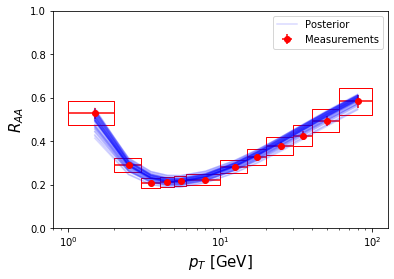

In [33]:
# predicting observables
param_samples = samples[ np.random.choice(range(len(samples)),50), :]
z  = np.array([gp.predict(param_samples) for gp in gps]).T
pred = np.dot(z, Trans_Matrix[:z.shape[-1]])
pred += scaler.mean_
for i, y in enumerate(pred):
    plt.plot(pT, y, 'b-', alpha=0.15, label="Posterior" if i==0 else '')
plt.errorbar(pT, yexp, yerr=ystat, xerr=pTbin, fmt='ro', label="Measurements")
for xl, xr, yl, yh in zip(pT-pTbin, pT+pTbin, yexp-ysys, yexp+ysys):
    plt.fill_between([xl,xr],[yl, yl], [yh, yh], facecolor='None', edgecolor='r')
plt.ylim(0,1)
plt.semilogx()
plt.xlabel(r'$p_T$ [GeV]', fontsize=15)
plt.ylabel(r'$R_{AA}$', fontsize=15)
plt.legend()
pass

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In [3]:
def eloss_fluctuation(x, alpha): # x = deltaE / <delta E> 
    Norm = alpha**alpha/gamma(alpha)
    return Norm * x**(alpha-1.) * np.exp(-alpha*x)

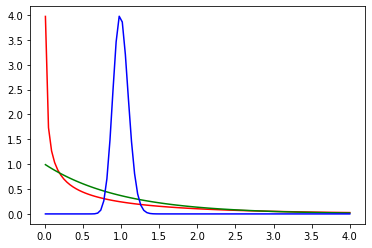

In [8]:
x = np.linspace(0.01,4,100)
plt.plot(x, eloss_fluctuation(x, alpha=.5),'r-')
plt.plot(x, eloss_fluctuation(x, alpha=1),'g-')
plt.plot(x, eloss_fluctuation(x, alpha=100),'b-')